# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [169]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [171]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [172]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [173]:
your_name = 'Arpana'

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [174]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [175]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
27,55,female,37.3635,2,no,13740.868120
752,64,male,43.2117,0,no,15915.800264
1258,55,male,42.9951,3,no,33671.210216
384,44,male,25.2339,2,no,9298.839928
406,33,female,27.7134,0,no,4687.309648


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [176]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns does the dataset have**

In [177]:
num_cols = dataframe.shape[1]
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [178]:
input_cols = dataframe.columns[:-1]
print(input_cols)

Index(['age', 'sex', 'bmi', 'children', 'smoker'], dtype='object')


**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [179]:
dataframe.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
charges     float64
dtype: object

In [180]:
categorical_cols = [x for x in input_cols if dataframe[x].dtypes=='object']
categorical_cols

['sex', 'smoker']

**Q: What are the column titles of output/target variable(s)?**

In [181]:
output_cols = [dataframe.columns[-1]]
output_cols

['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


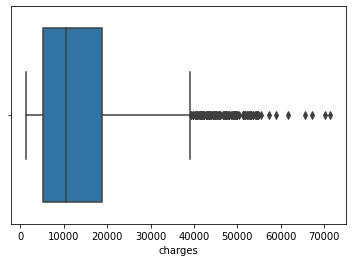

In [182]:
sns.boxplot(dataframe.charges)

Data is right skewed and has many outliers, median value looks like 10000 and outliers are greater than 40000.

In [183]:
dataframe.charges.describe()

count     1271.000000
mean     14888.432516
std      13611.709658
min       1256.498768
25%       5285.127456
50%      10518.307520
75%      18861.548126
max      71422.879371
Name: charges, dtype: float64

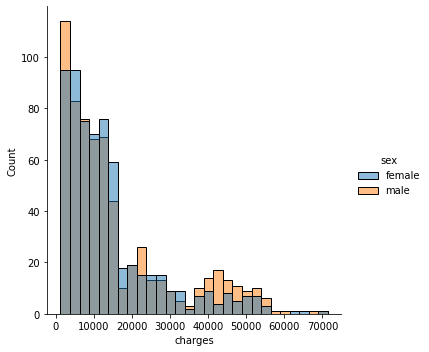

In [184]:
sns.displot(dataframe,x='charges', hue='sex')

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [185]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [186]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[55.    ,  0.    , 37.3635,  2.    ,  0.    ],
        [64.    ,  1.    , 43.2117,  0.    ,  0.    ],
        [55.    ,  1.    , 42.9951,  3.    ,  0.    ],
        ...,
        [56.    ,  1.    , 29.5659,  0.    ,  0.    ],
        [18.    ,  0.    , 34.5477,  0.    ,  0.    ],
        [43.    ,  1.    , 29.6742,  0.    ,  0.    ]]), array([[13740.86812 ],
        [15915.800264],
        [33671.210216],
        ...,
        [12505.267768],
        [ 2468.184264],
        [ 7657.852944]]))

In [72]:
# inputs_array.reshape(-1,5).shape, targets_array.reshape(-1,1).shape

((1271, 5), (1271, 1))

**Let's standardize the data as the values have outliers and varied**

In [112]:
# sc = MinMaxScaler()
# sct = MinMaxScaler()
# inputs_array =sc.fit_transform(inputs_array.reshape(-1,5))
# targets_array =sct.fit_transform(targets_array.reshape(-1,1))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [187]:
inputs = torch.tensor(inputs_array).type(torch.float32)
# inputs = inputs.view(-1,5)
targets = torch.tensor(targets_array).type(torch.float32)
# targets = targets.view(-1,1)

In [188]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [189]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [190]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

# Use the random_split function to split dataset into 2 parts of the desired length
train_ds, val_ds = random_split(dataset,[train_size, val_size])

In [191]:
len(train_ds),len(val_ds)

(1081, 190)

In [192]:
train_ds[0],val_ds[0]

((tensor([25.0000,  0.0000, 27.7020,  3.0000,  0.0000]), tensor([4918.6504])),
 (tensor([37.0000,  0.0000, 35.0892,  0.0000,  1.0000]), tensor([41742.5703])))

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [193]:
batch_size = 80

In [194]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [195]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[28.0000,  0.0000, 27.1833,  2.0000,  0.0000],
        [52.0000,  0.0000, 36.1722,  2.0000,  0.0000],
        [46.0000,  0.0000, 32.9460,  2.0000,  0.0000],
        [59.0000,  1.0000, 32.8149,  0.0000,  0.0000],
        [42.0000,  0.0000, 43.2060,  0.0000,  0.0000],
        [21.0000,  1.0000, 35.3628,  0.0000,  0.0000],
        [37.0000,  0.0000, 19.7106,  2.0000,  0.0000],
        [57.0000,  1.0000, 48.0282,  1.0000,  1.0000],
        [60.0000,  0.0000, 41.0457,  0.0000,  0.0000],
        [30.0000,  1.0000, 43.0920,  2.0000,  1.0000],
        [18.0000,  1.0000, 46.8996,  0.0000,  0.0000],
        [18.0000,  0.0000, 43.5138,  0.0000,  0.0000],
        [43.0000,  1.0000, 31.6920,  0.0000,  1.0000],
        [19.0000,  1.0000, 31.4640,  0.0000,  0.0000],
        [59.0000,  0.0000, 39.6720,  2.0000,  0.0000],
        [36.0000,  0.0000, 33.1056,  4.0000,  0.0000],
        [23.0000,  0.0000, 35.7960,  0.0000,  1.0000],
        [34.0000,  1.0000, 31.7319,  1.0000,  1.0000],
  

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [196]:
input_size = len(input_cols)
output_size = len(output_cols)
input_size, output_size

(5, 1)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [197]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,output_size) 
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        # loss = F.mse_loss(out, targets)                         # fill this
        loss = F.l1_loss(out, target)
        # loss = nn.MSELoss(out,targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        # loss = F.mse_loss(out, targets)                          # fill this    
        loss = F.l1_loss(out, target)
        # loss = nn.MSELoss(out,targets)
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [240]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [241]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2004, -0.2003,  0.0757,  0.3888, -0.1100]], requires_grad=True),
 Parameter containing:
 tensor([0.3410], requires_grad=True)]

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [200]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [242]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 14030.7294921875}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [243]:
epochs = 100
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)
history1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size(

Epoch [20], val_loss: 6352.9224
Epoch [40], val_loss: 2669.2825
Epoch [60], val_loss: 2475.2209
Epoch [80], val_loss: 2390.7744
Epoch [100], val_loss: 2315.3708


[{'val_loss': 13647.5859375},
 {'val_loss': 13263.9296875},
 {'val_loss': 12880.1103515625},
 {'val_loss': 12495.9248046875},
 {'val_loss': 12112.0654296875},
 {'val_loss': 11728.7333984375},
 {'val_loss': 11344.6025390625},
 {'val_loss': 10960.8134765625},
 {'val_loss': 10577.2470703125},
 {'val_loss': 10192.7509765625},
 {'val_loss': 9809.7724609375},
 {'val_loss': 9425.015625},
 {'val_loss': 9040.2265625},
 {'val_loss': 8655.0751953125},
 {'val_loss': 8271.87109375},
 {'val_loss': 7888.22314453125},
 {'val_loss': 7504.04638671875},
 {'val_loss': 7119.791015625},
 {'val_loss': 6736.52490234375},
 {'val_loss': 6352.92236328125},
 {'val_loss': 5969.0078125},
 {'val_loss': 5584.74267578125},
 {'val_loss': 5200.04345703125},
 {'val_loss': 4817.80810546875},
 {'val_loss': 4445.89990234375},
 {'val_loss': 4110.69287109375},
 {'val_loss': 3830.520751953125},
 {'val_loss': 3592.686279296875},
 {'val_loss': 3394.518310546875},
 {'val_loss': 3233.251953125},
 {'val_loss': 3104.486572265625},
 

In [244]:
epochs = 100
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size(

Epoch [20], val_loss: 2308.6985
Epoch [40], val_loss: 2302.3611
Epoch [60], val_loss: 2295.9473
Epoch [80], val_loss: 2289.5786
Epoch [100], val_loss: 2283.3604


In [245]:
epochs = 100
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size(

Epoch [20], val_loss: 2282.7258
Epoch [40], val_loss: 2282.1086
Epoch [60], val_loss: 2281.4766
Epoch [80], val_loss: 2280.8535
Epoch [100], val_loss: 2280.2305


In [246]:
epochs = 100
lr = 1e-5
history4 = fit(epochs, lr, model, train_loader, val_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size(

Epoch [20], val_loss: 2280.1677
Epoch [40], val_loss: 2280.1045
Epoch [60], val_loss: 2280.0415
Epoch [80], val_loss: 2279.9788
Epoch [100], val_loss: 2279.9167


In [247]:
epochs = 100
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size(

Epoch [20], val_loss: 2279.9131
Epoch [40], val_loss: 2279.9094
Epoch [60], val_loss: 2279.9058
Epoch [80], val_loss: 2279.9021
Epoch [100], val_loss: 2279.8972


In [248]:
epochs = 100
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size(

Epoch [20], val_loss: 2279.8933
Epoch [40], val_loss: 2279.8896
Epoch [60], val_loss: 2279.8850
Epoch [80], val_loss: 2279.8806
Epoch [100], val_loss: 2279.8765


**Q: What is the final validation loss of your model?**

In [249]:
val_loss = history4[-1]
val_loss

{'val_loss': 2279.916748046875}

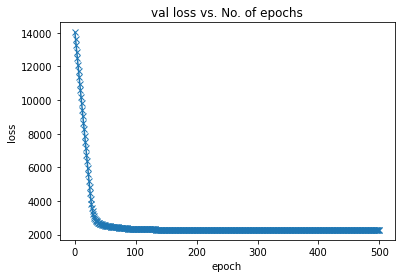

In [250]:
history = [result] + history1 + history2 + history3 + history4 + history5
losses = [result['val_loss'] for result in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('val loss vs. No. of epochs');

Looks like validation loss doesn't change much after 5 epochs

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [45]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [231]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)               # fill this
    prediction = predictions[0].detach()
    # 
    # print("Input:", sc.inverse_transform(input.reshape(-1,5)))
    print("Input:", input)
    # print("Target:", sct.inverse_transform(target.reshape(-1,1)))
    print("Target:", target)
    # prediction = sigmoid(prediction)
    # prediction = sct.inverse_transform(prediction.reshape(-1,1))    
    # print("Prediction:", sct.inverse_transform(prediction.reshape(-1,1)))
    print("Prediction:", prediction)

In [254]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([37.0000,  0.0000, 35.0892,  0.0000,  1.0000])
Target: tensor([41742.5703])
Prediction: tensor([12996.4951])


In [252]:
input, target = val_ds[20]
predict_single(input, target, model)

Input: tensor([60.0000,  1.0000, 27.7248,  0.0000,  0.0000])
Target: tensor([14026.4375])
Prediction: tensor([14976.6992])


In [253]:
input, target = val_ds[14]
predict_single(input, target, model)

Input: tensor([57.0000,  1.0000, 20.9019,  0.0000,  0.0000])
Target: tensor([12919.0576])
Prediction: tensor([13092.6494])


Are you happy with your model's predictions? Try to improve them further.